In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

#Atomic Constants
me = 9.1093837e-31 # mass of an electron
mH = 1.673557695220333e-27 # mass of Hydrogen
mT = 5.0082676661837955e-27 # mass of Tritium
mue = 9.2740100657e-24 #Magnetic moment of an electron J/T
mup = 1.41060679545e-26 #Magnetic moment of a proton J/T
ge = 2.002319 #Electron g-factor

#Hyperfine Constants
gL = 1 #Orbital g-factor
gS = 2 #Electron spin g-factor
L = 0 #Orbital Angular Momentum
S = .5 #Electron spin
I = .5 #Nuclear spin
J = .5 #Total Angular Momentum

delW = 1.428e9 #Hyperfine splitting constant in Hz
gI = 5.585 # Nuclear g-factor

#Important Conversion Factors
Bohr2m = .529177e-10
Dalton2kg = 1.66053906892e-27
Dalton2eV=931.49410372e6
invB2eV = 27.211386245988
J2invB = 2.2937e17
eV2J = 1.602176634e-19
Tesla2invB = 2.293712e17
kg2eV = 1.78266192e-36
kg2au = 9.1093837e-31

In [3]:
#Important Potentials 
#Most modern Silvera Triplet Potential
def Silvera_Triplet(R):
    x=R*Bohr2m/4.16e-10
    D=1.28
    KToH=315775
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46/KToH*(4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

#Old School Silvera Triplet Potential, used to measure uncertainties 
def Triplet(R): 
    return np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)

#Dipolar Interaction Potential 
def Dipolar(R):
    return mue * J2invB * np.sqrt(4 * np.pi/5 ) / (4*np.pi*R**3) * (2 * mup * J2invB - mue * J2invB)

In [4]:

#As part of the Dipolar Relaxation calculation one must first find the solution to the elastic scattering schrodinger equation
#The solution changes for different Triplet potentials, masses, angular momenta contributions, and relative momenta

#Setting up the Schrodinger Equation
def ddx(y, r, muove, Potential, l, p):#The mass term should be for reduced mass over electron mass
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-p**2 + 2 * muove * Potential(r) + l * (l + 1) / (r**2)) * u
    return [dudr,dvdr]

#Solving the ODE and setting up the normalized state that will be put into the calculation
def Wave_Function(p, l, A, r0, function, muove, version, int_type):
    rhos = np.linspace(r0, A, int(A)*10)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, muove, Silvera_Triplet, l, p)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0] ,rhos[-1]),init,t_eval=rhos,method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/p)**2)
    return State.y[0]/Normalization[-1]

#Now that the states have been effectively defined the actual integral for the dipolar lose rates needs to be constructed. 
def GetIntegrals (alphain, betain, alphaout, betaout, A, r0, temp , how_to_int):
    rhos = np.linspace(r0, A, int(A)*10)
    
    P1H = p_of_temp( mH / (2 * kg2au), temp)
    P1T = p_of_temp( mT / (2 * kg2au), temp)
    P2H = pprime(P1H, alphain, betain, alphaout, betaout, mH / (2 * kg2au))
    P2T = pprime(P1T, alphain, betain, alphaout, betaout, mT / (2 * kg2au))
    
    HinState = np.array(Wave_Function(P1H, 0, A, r0, ddx, mH / (2 * me), Silvera_Triplet, how_to_int))
    TinState = np.array(Wave_Function(P1T, 0, A, r0, ddx, mT / (2 * me), Silvera_Triplet, how_to_int))
    HoutState = np.array(Wave_Function(P2H, 2, A, r0, ddx, mH / (2 * me), Silvera_Triplet, how_to_int))
    ToutState = np.array(Wave_Function(P2T, 2, A, r0, ddx, mT / (2 * me), Silvera_Triplet, how_to_int))

    HIntegrand = interp1d(rhos, HinState * HoutState / rhos**3, kind = 'linear')
    TIntegrand = interp1d(rhos, TinState * ToutState / rhos**3, kind = 'linear')

    if A <= 250:
        HIntegral = quad(HIntegrand,rhos[0],rhos[-1])[0]/(P1H*P2H)
        TIntegral = quad(TIntegrand,rhos[0],rhos[-1])[0]/(P1T*P2T)
    else:
        HIntegral1 = quad(HIntegrand,rhos[0],250)[0]/(P1H*P2H)
        TIntegral1 = quad(TIntegrand,rhos[0],250)[0]/(P1T*P2T)

        HIntegral2 = quad(HIntegrand,250,rhos[-1])[0]/(P1H*P2H)
        TIntegral2 = quad(TIntegrand,250,rhos[-1])[0]/(P1T*P2T)

        HIntegral = HIntegral1 + HIntegral2
        TIntegral = TIntegral1 + TIntegral2

    return(HIntegral, TIntegral)

In [5]:
#We want to see the ratios for both identical momentums and for identical temperatures 
#Therefore a means of determining momentum from temperature is necessary 
#Additionally a method of determining outward going momenta is necessary
def p_of_temp(mu, T):
    return np.sqrt(2 * mu * kb * J2invB * T)

def pprime(p,epsa,epsb,epsprimea,epsprimeb,mu):
    E = p**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt( 2 * mu * Eprime)
    return pprime

Text(0.5, 0, 'B (T)')

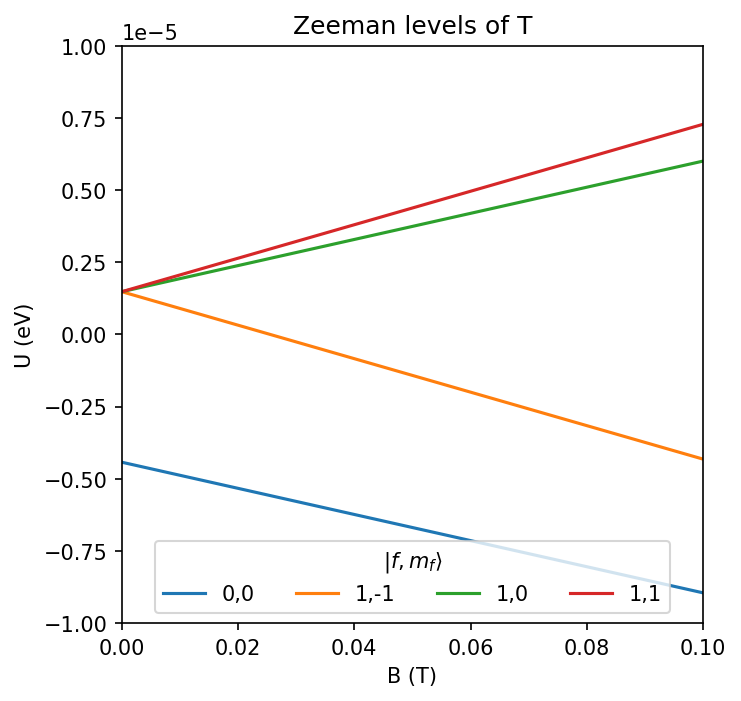

In [6]:
#The outward going momenta is clearly a function of the hyperfine levels
B = np.linspace(1e-5,10,50) #range of relavent magnetic fields

def GetHyperFineLevels(pm, mf, delW, mN, gI): #Input field in Tesla, outputs energy in eV
    meeV = me / kg2eV
    muN = mue*meeV/(mN*1e9)
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B)
    Term2 = muN * gI * mf * B

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h / eV2J

def AllHFLevels(delW, mN, gI): #This creates the array of values for each important level
    delEs = []
    for pm in [-1,1]:
        F = I + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

cols = ['DarkRed','DarkBlue','Purple','Black']
plt.figure(figsize=(5,5),dpi=150)
for pm in [-1,1]:
    F = I + pm/2
    for mF in np.arange(-F,F+1,1):
        delE = GetHyperFineLevels(pm,mF,delW,mT/Dalton2kg,gI)
        plt.plot(B,delE,label=str(int(F))+","+str(int(mF)))
        
plt.xlim(0,0.1)
plt.ylim(-1e-5,1e-5)
plt.title(r"Zeeman levels of T")
plt.legend(loc='lower center',ncol=4,title=r'$|f,m_f\rangle$' )
plt.ylabel("U (eV)")
plt.xlabel("B (T)")

In [7]:
Levels = AllHFLevels(delW, mT / Dalton2kg, gI)
letters = ['a', 'c', 'd']

In [8]:
GHaa1_Elements = []
GTaa1_Elements = []
GHac1_Elements = []
GTac1_Elements = []
GHad1_Elements = []
GTad1_Elements = []
GHaa2_Elements = []
GTaa2_Elements = []
GHac2_Elements = []
GTac2_Elements = []
GHad2_Elements = []
GTad2_Elements = []
GHaa3_Elements = []
GTaa3_Elements = []
GHac3_Elements = []
GTac3_Elements = []
GHad3_Elements = []
GTad3_Elements = []
for let in letters:
    i = 0
    for b in B:
        a = Levels['d'][i] / invB2eV
        b = Levels['d'][i] / invB2eV
        alpha = Levels['a'][i] / invB2eV
        beta = Levels[let][i] / invB2eV
        r0 = 1e-3
        temp = 1e-3
        intlimit = 2000

        P1H = p_of_temp( mH / (2 * kg2au) , temp)
        P1T = p_of_temp( mT / (2 * kg2au) , temp)
        P2H = pprime(P1H, a, b, alpha, beta, mH / (2 * kg2au))
        P2T = pprime(P1T, a, b, alpha, beta, mT / (2 * kg2au))

        IntegralsH1, IntegralsT1 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'Radau')
        IntegralsH2, IntegralsT2 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'DOP853')
        IntegralsH3, IntegralsT3 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'RK45')
        
        GH1_Element = mH / (2 * kg2au) * P2H * IntegralsH1**2
        GT1_Element = mT / (2 * kg2au) * P2T * IntegralsT1**2
        GH2_Element = mH / (2 * kg2au) * P2H * IntegralsH2**2
        GT2_Element = mT / (2 * kg2au) * P2T * IntegralsT2**2
        GH3_Element = mH / (2 * kg2au) * P2H * IntegralsH3**2
        GT3_Element = mT / (2 * kg2au) * P2T * IntegralsT3**2

        if let == 'a':
            GHaa1_Elements.append(GH1_Element)
            GTaa1_Elements.append(GT1_Element)
            GHaa2_Elements.append(GH2_Element)
            GTaa2_Elements.append(GT2_Element)
            GHaa3_Elements.append(GH3_Element)
            GTaa3_Elements.append(GT3_Element)
        elif let == 'c':
            GHac1_Elements.append(GH1_Element)
            GTac1_Elements.append(GT1_Element)
            GHac2_Elements.append(GH2_Element)
            GTac2_Elements.append(GT2_Element)
            GHac3_Elements.append(GH3_Element)
            GTac3_Elements.append(GT3_Element)
        elif let == 'd':
            GHad1_Elements.append(GH1_Element)
            GTad1_Elements.append(GT1_Element) 
            GHad2_Elements.append(GH2_Element)
            GTad2_Elements.append(GT2_Element) 
            GHad3_Elements.append(GH3_Element)
            GTad3_Elements.append(GT3_Element) 

        i = i+1
GHaa1_Elements = np.array(GHaa1_Elements)
GTaa1_Elements = np.array(GTaa1_Elements)
GHac1_Elements = np.array(GHac1_Elements)
GTac1_Elements = np.array(GTac1_Elements)
GHad1_Elements = np.array(GHad1_Elements)
GTad1_Elements = np.array(GTad1_Elements)
GHaa2_Elements = np.array(GHaa2_Elements)
GTaa2_Elements = np.array(GTaa2_Elements)
GHac2_Elements = np.array(GHac2_Elements)
GTac2_Elements = np.array(GTac2_Elements)
GHad2_Elements = np.array(GHad2_Elements)
GTad2_Elements = np.array(GTad2_Elements)               
GHaa3_Elements = np.array(GHaa3_Elements)
GTaa3_Elements = np.array(GTaa3_Elements)
GHac3_Elements = np.array(GHac3_Elements)
GTac3_Elements = np.array(GTac3_Elements)
GHad3_Elements = np.array(GHad3_Elements)
GTad3_Elements = np.array(GTad3_Elements)               

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  TIntegral1 = quad(TIntegrand,rhos[0],250)[0]/(P1T*P2T)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  TIntegral1 = quad(TIntegrand,rhos[0],250)[0]/(P1T*P2T)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:47: IntegrationWarning: 

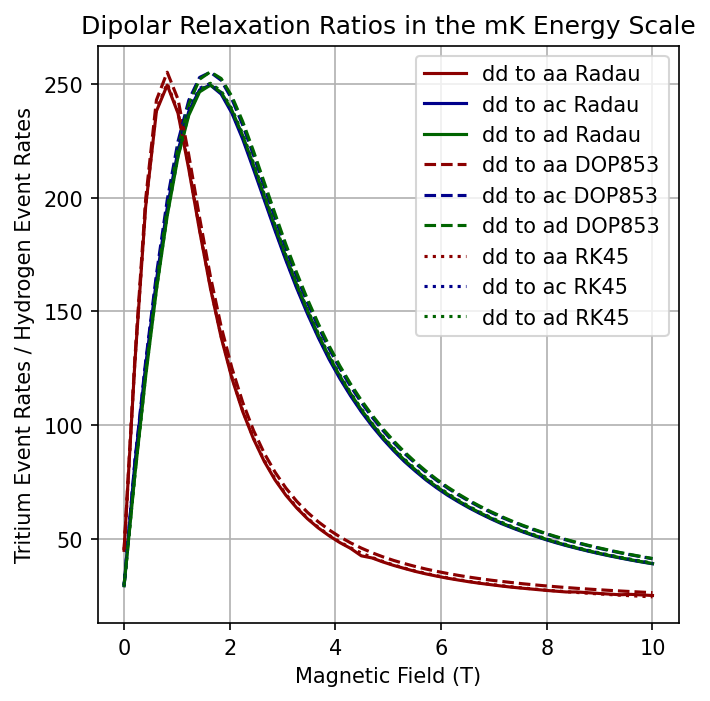

In [9]:
plt.figure(figsize=(5, 5),dpi=150)
plt.plot(B, GTaa1_Elements/GHaa1_Elements, label="dd to aa Radau",  color="DarkRed",   linestyle='-')
plt.plot(B, GTac1_Elements/GHac1_Elements, label="dd to ac Radau",  color="DarkBlue",  linestyle='-')
plt.plot(B, GTad1_Elements/GHad1_Elements, label="dd to ad Radau",  color="DarkGreen", linestyle='-')

plt.plot(B, GTaa2_Elements/GHaa2_Elements, label="dd to aa DOP853", color="DarkRed",   linestyle='--')
plt.plot(B, GTac2_Elements/GHac2_Elements, label="dd to ac DOP853", color="DarkBlue",  linestyle='--')
plt.plot(B, GTad2_Elements/GHad2_Elements, label="dd to ad DOP853", color="DarkGreen", linestyle='--')

plt.plot(B, GTaa3_Elements/GHaa3_Elements, label="dd to aa RK45",   color="DarkRed",   linestyle=':')
plt.plot(B, GTac3_Elements/GHac3_Elements, label="dd to ac RK45",   color="DarkBlue",  linestyle=':')
plt.plot(B, GTad3_Elements/GHad3_Elements, label="dd to ad RK45",   color="DarkGreen", linestyle=':')

plt.xlabel("Magnetic Field (T)")
#plt.xlim(0,.1)
plt.ylabel("Tritium Event Rates / Hydrogen Event Rates")
#plt.ylim(0,140)
plt.title("Dipolar Relaxation Ratios in the mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()

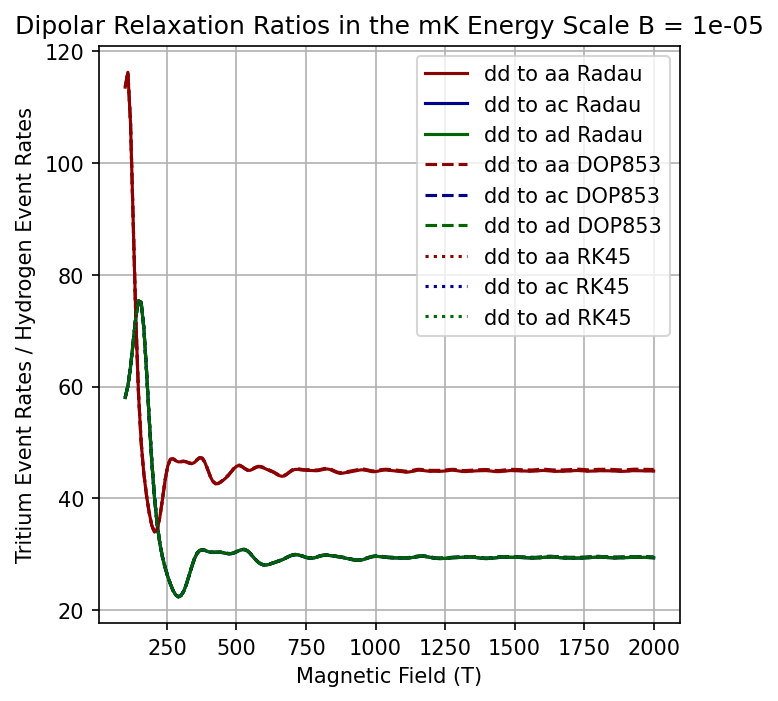

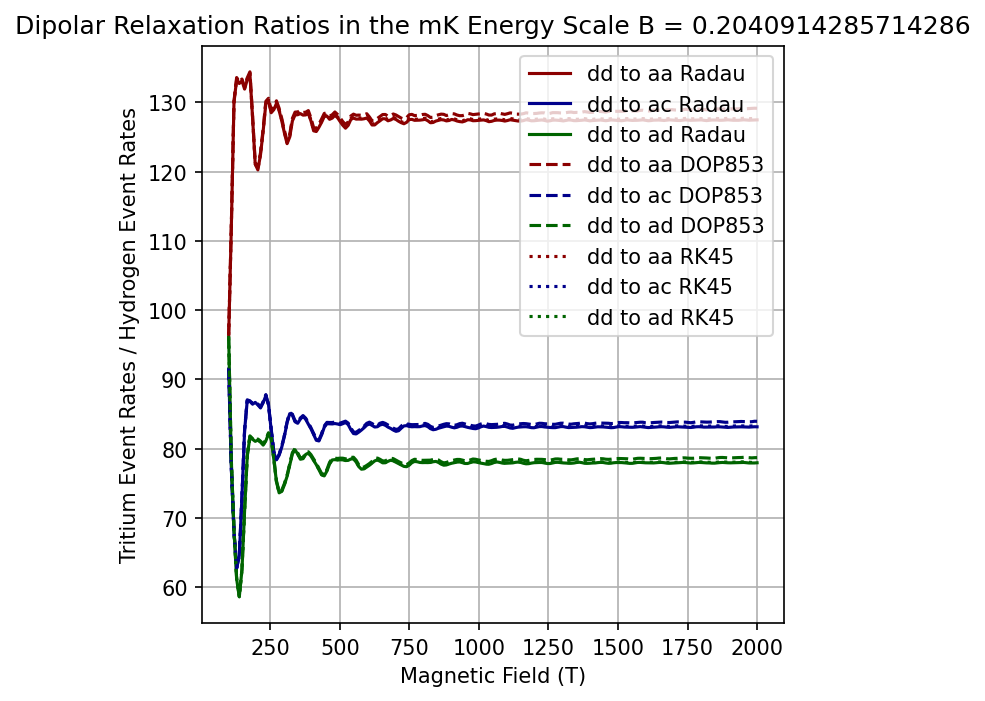

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:41: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  TIntegral = quad(TIntegrand,rhos[0],rhos[-1])[0]/(P1T*P2T)


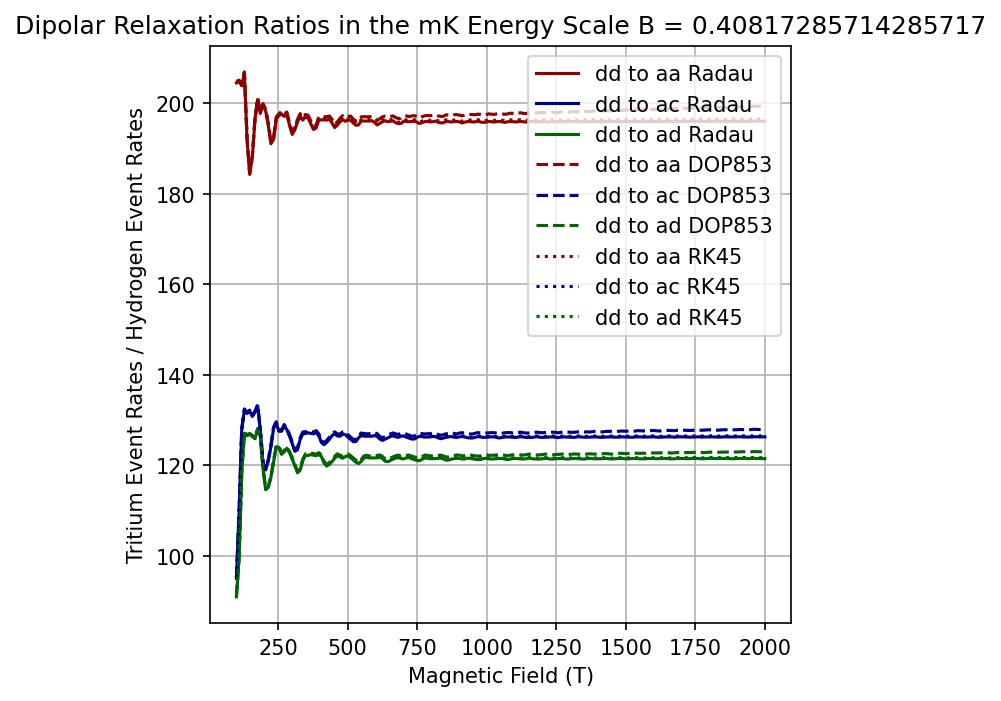

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  TIntegral = quad(TIntegrand,rhos[0],rhos[-1])[0]/(P1T*P2T)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

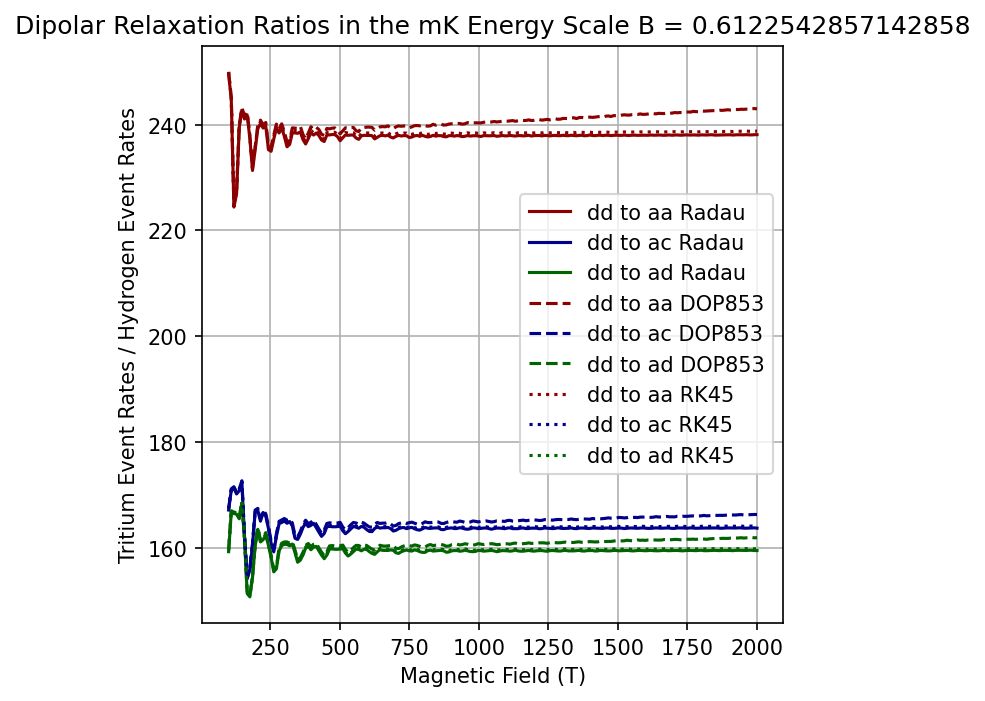

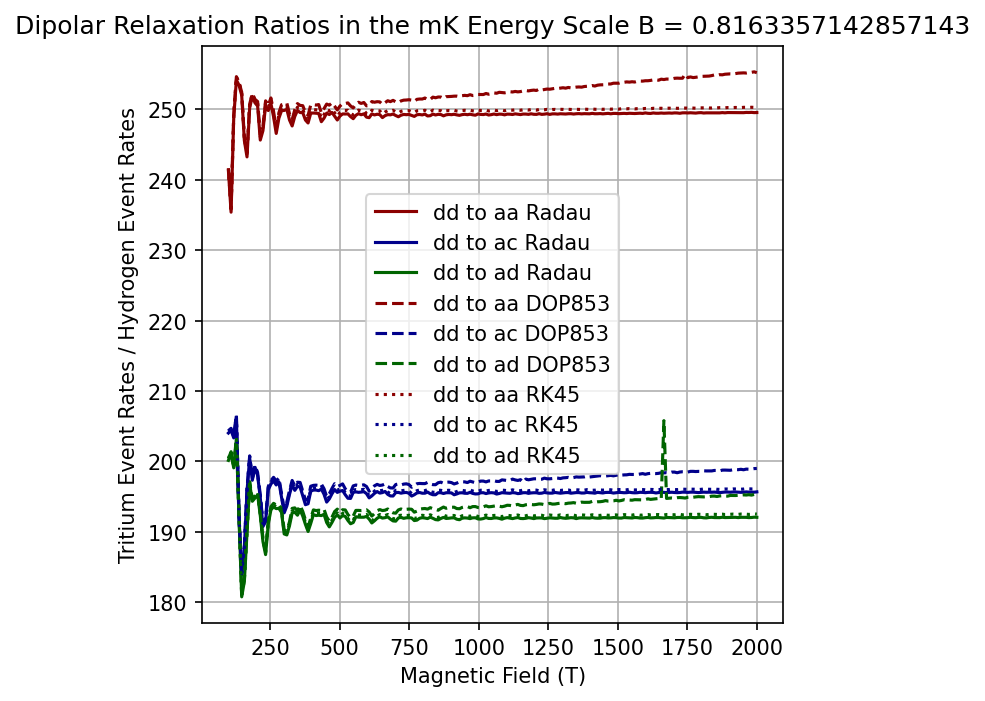

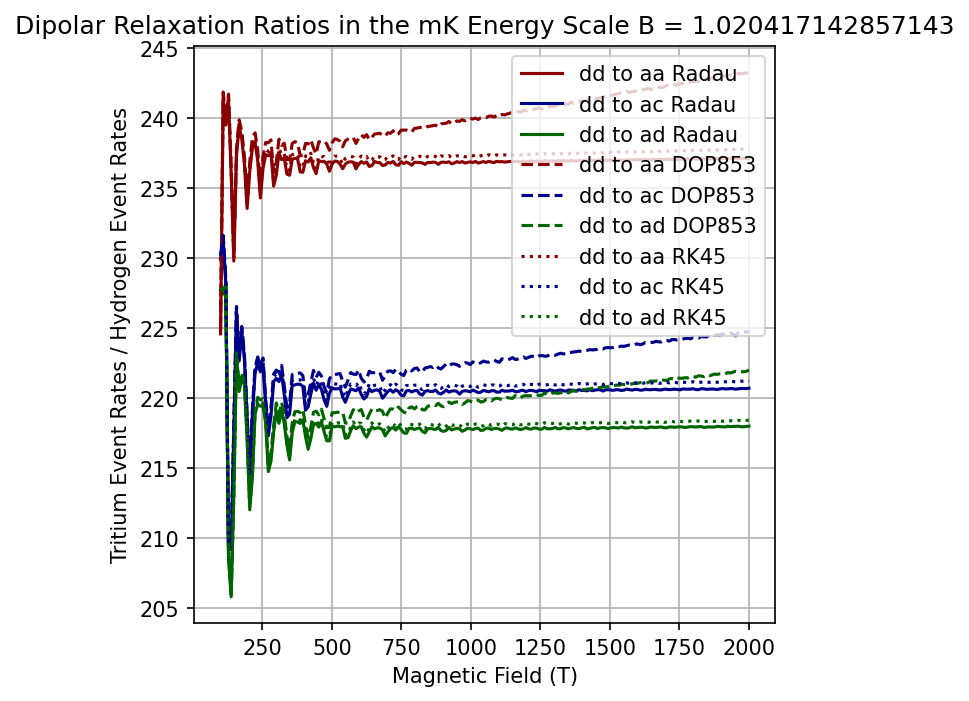

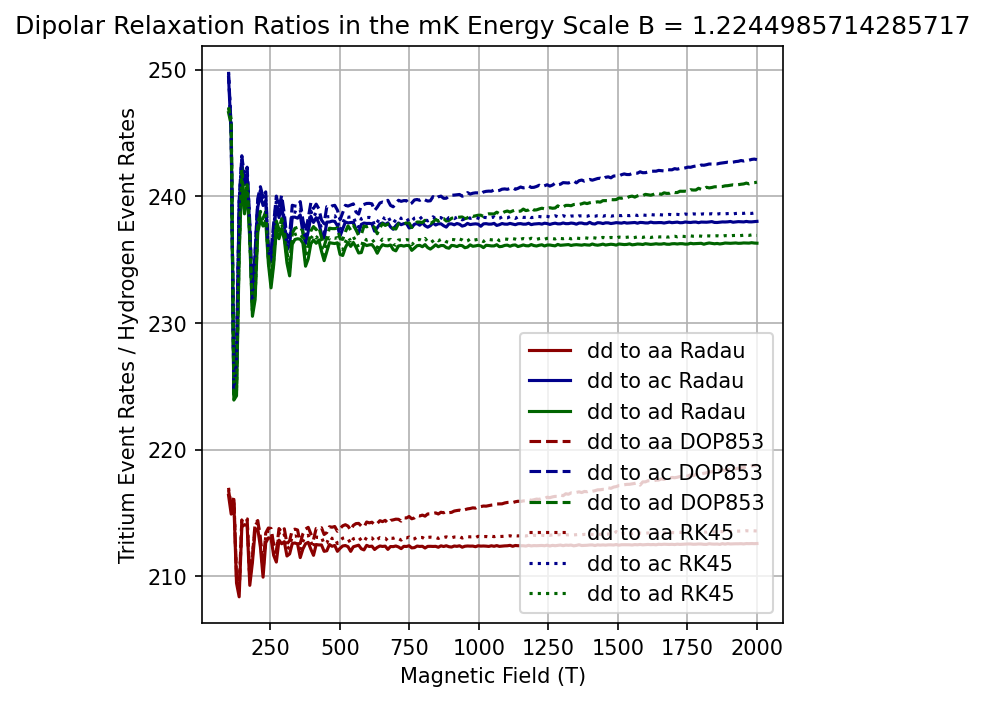

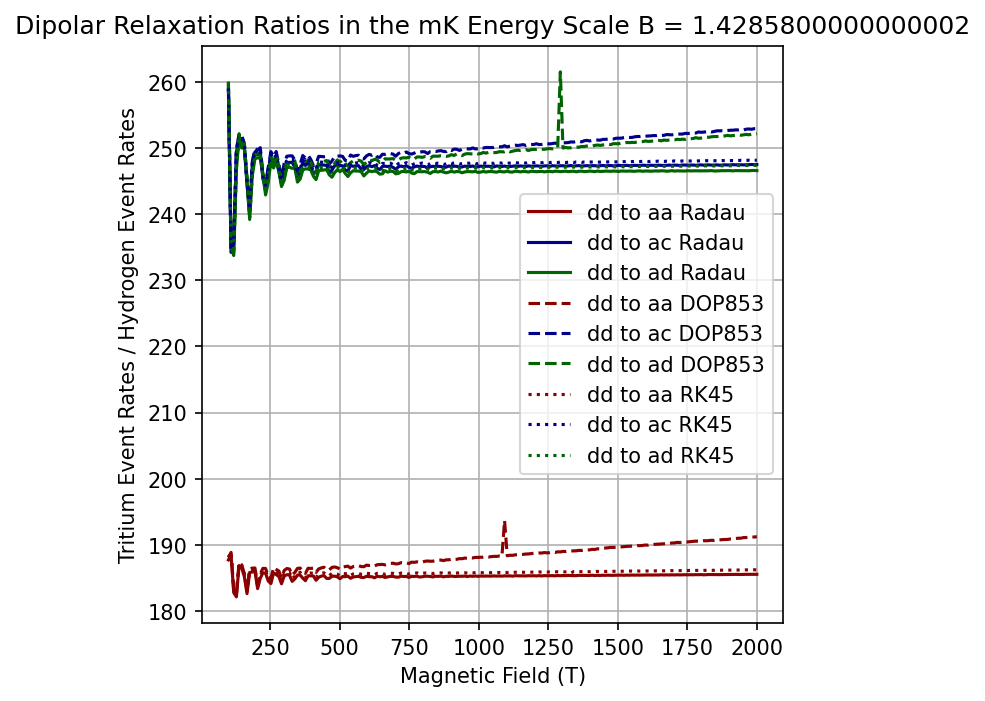

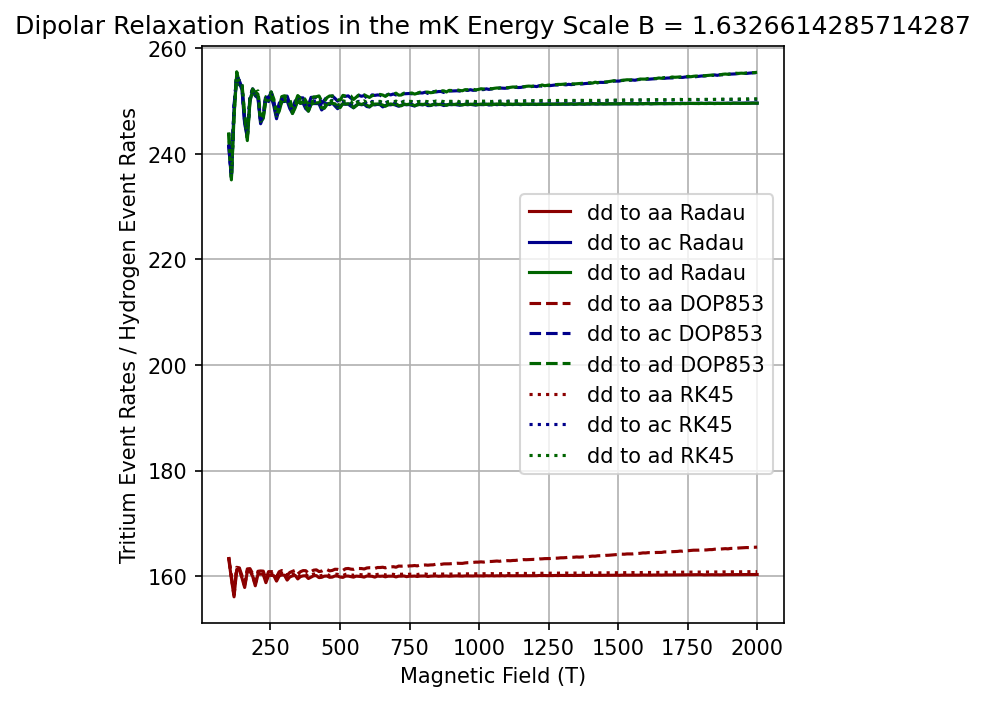

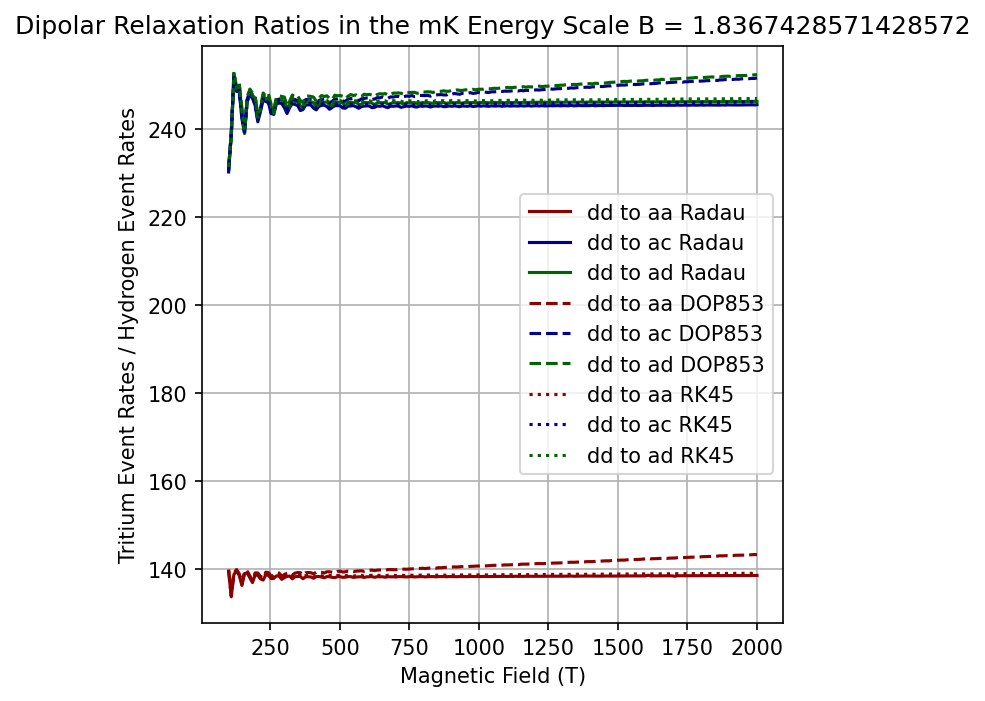

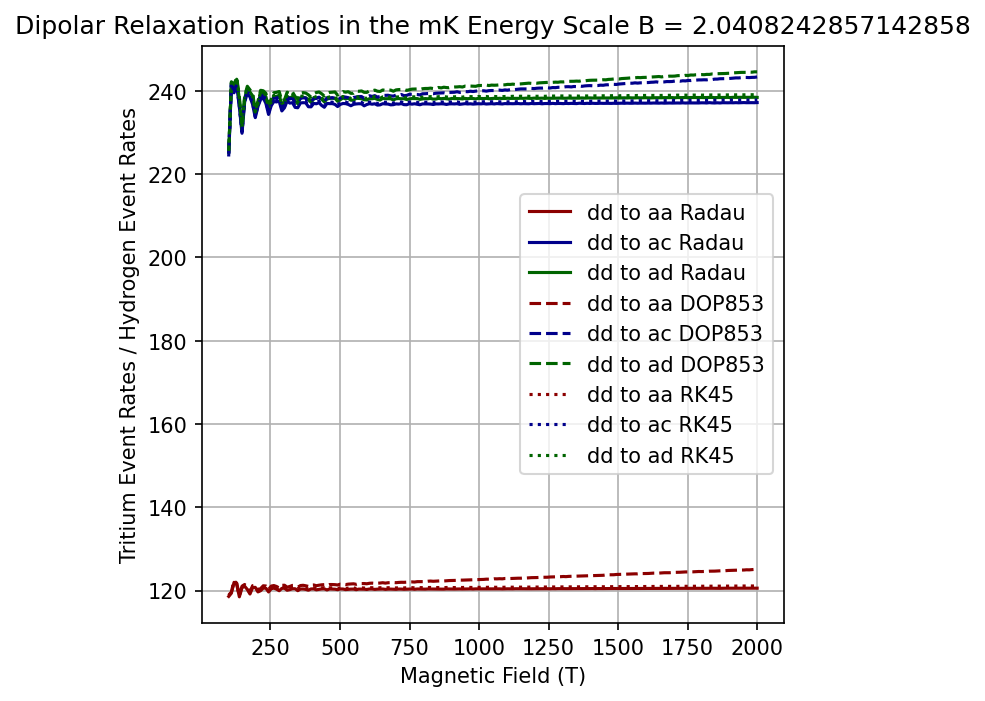

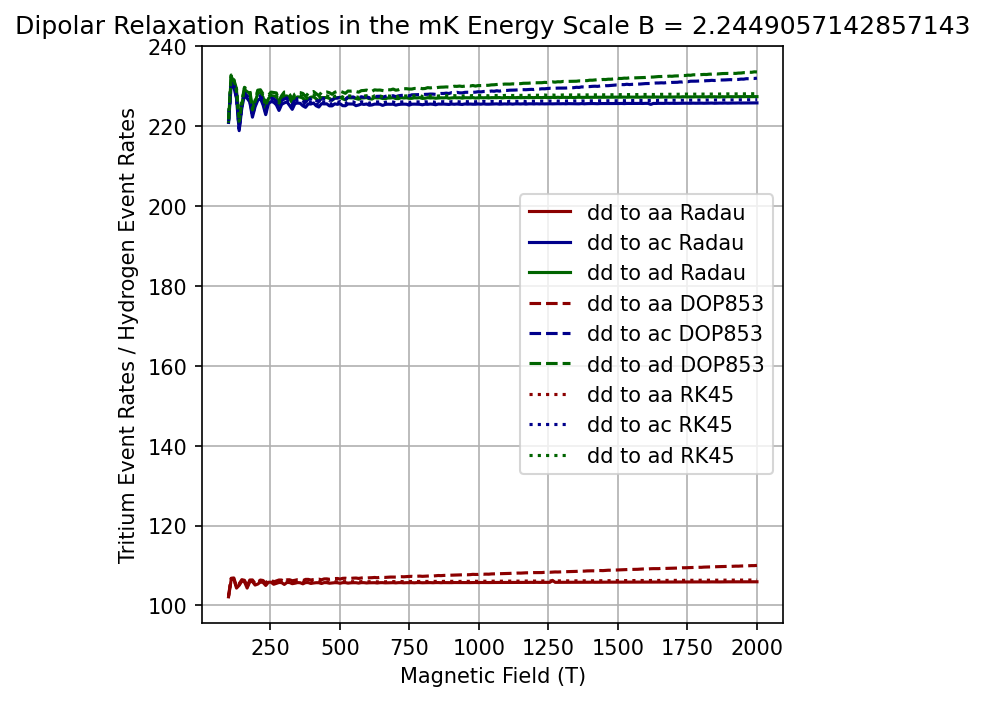

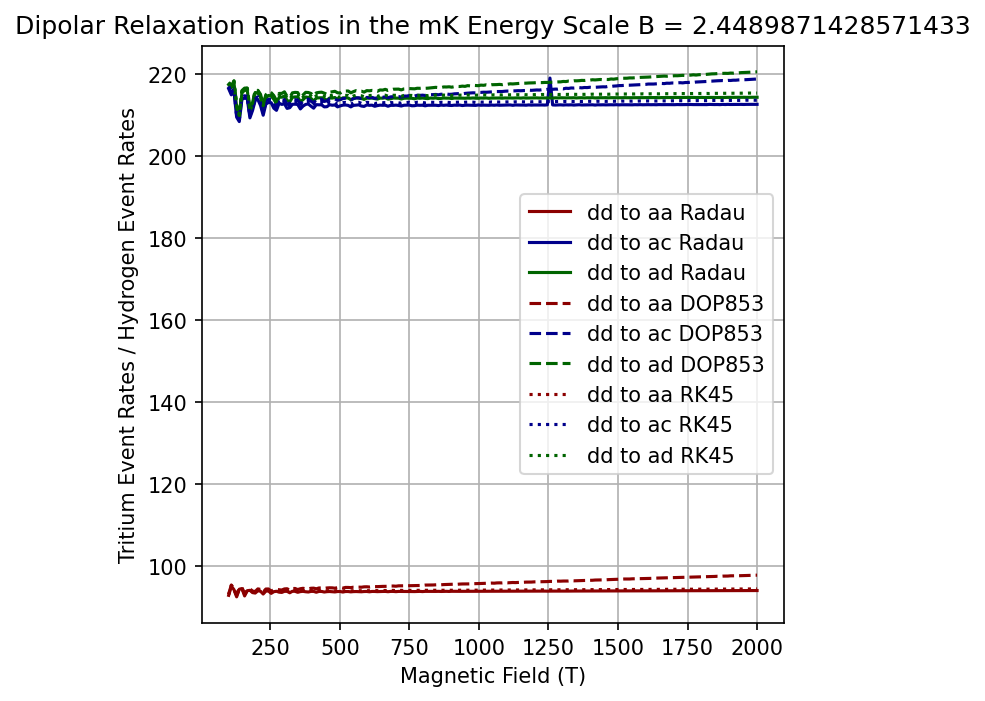

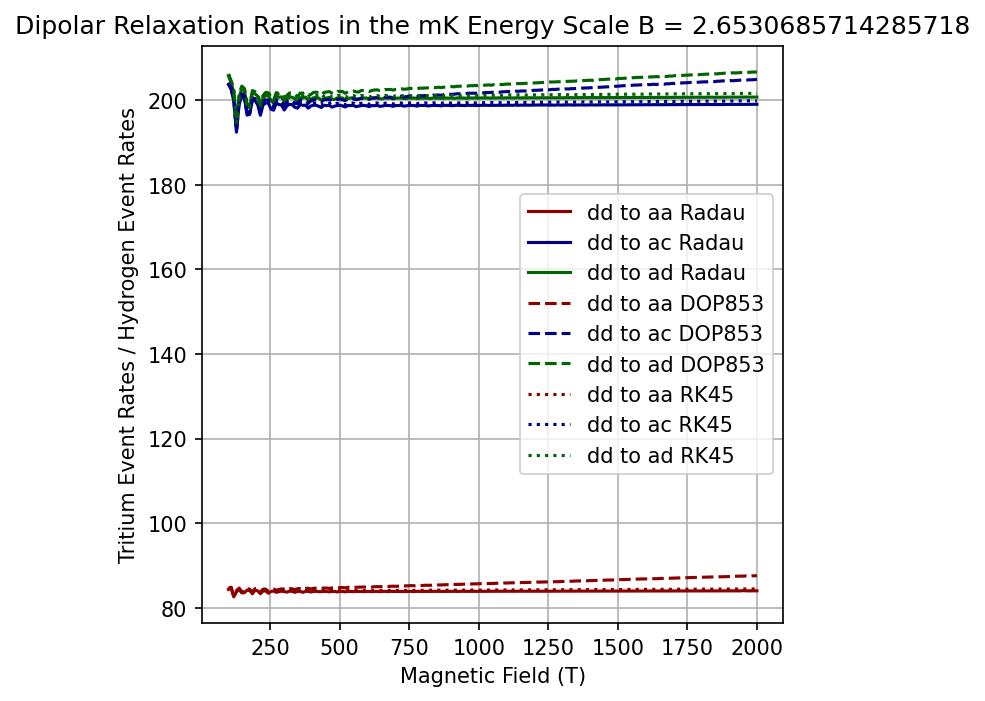

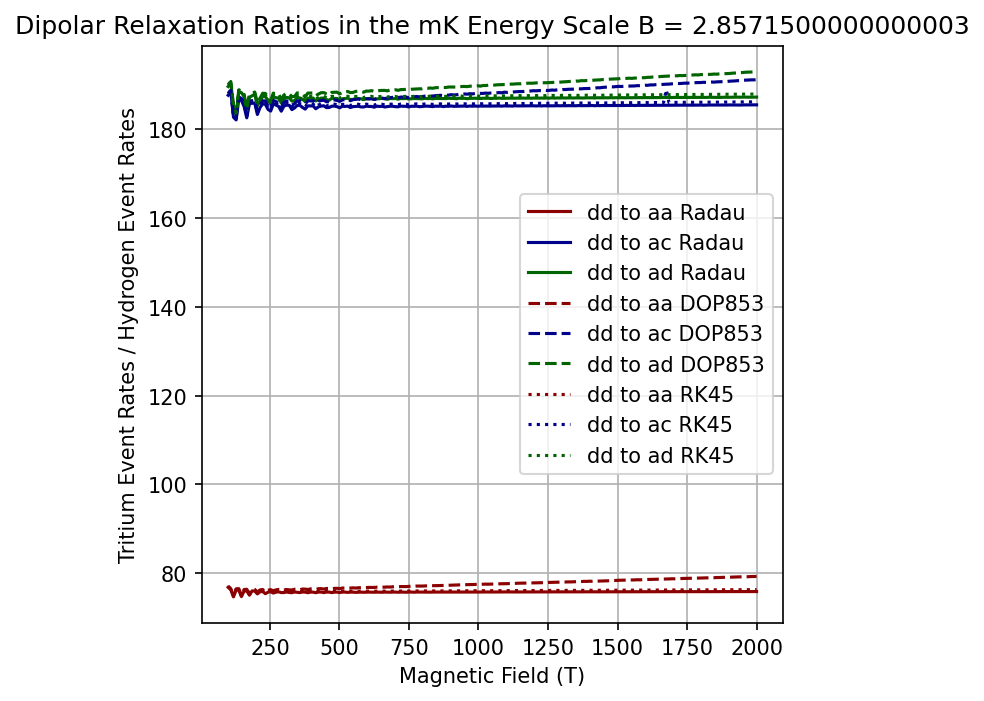

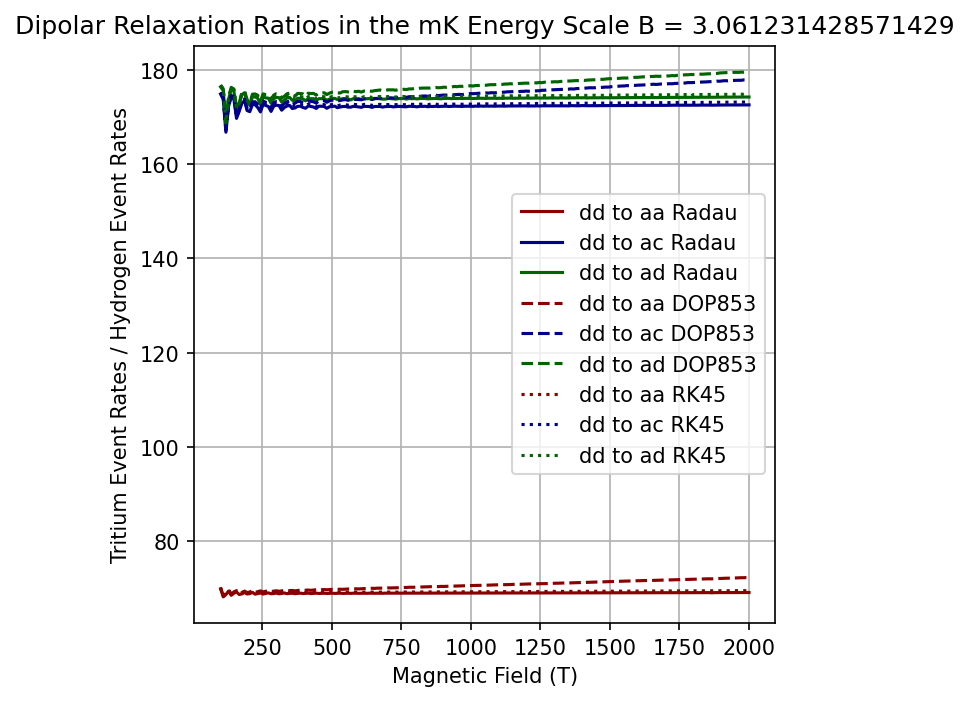

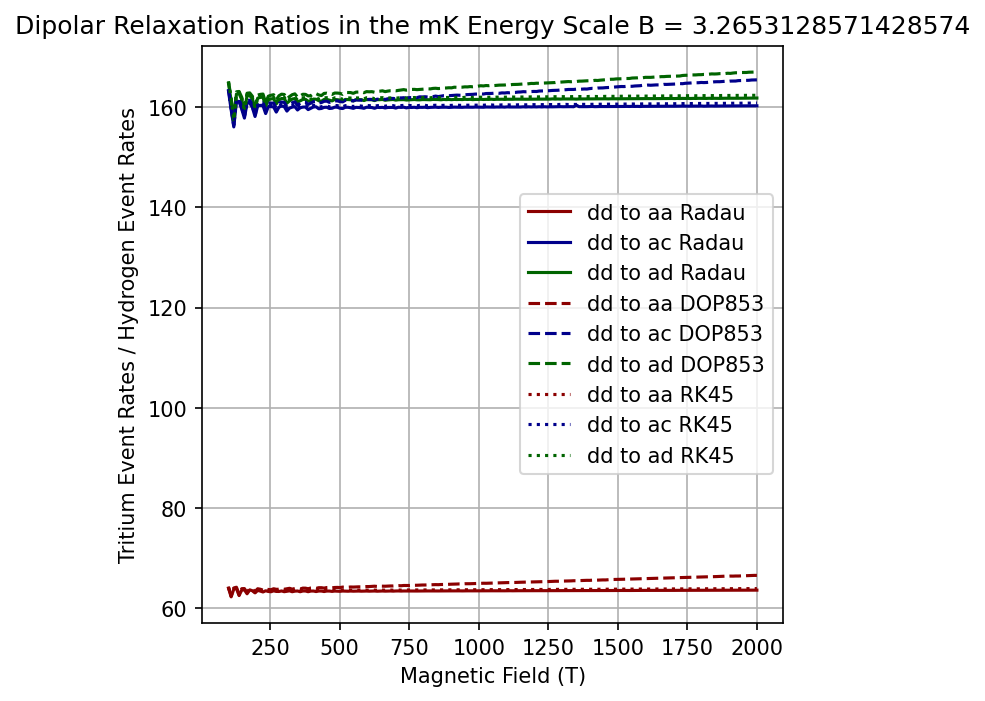

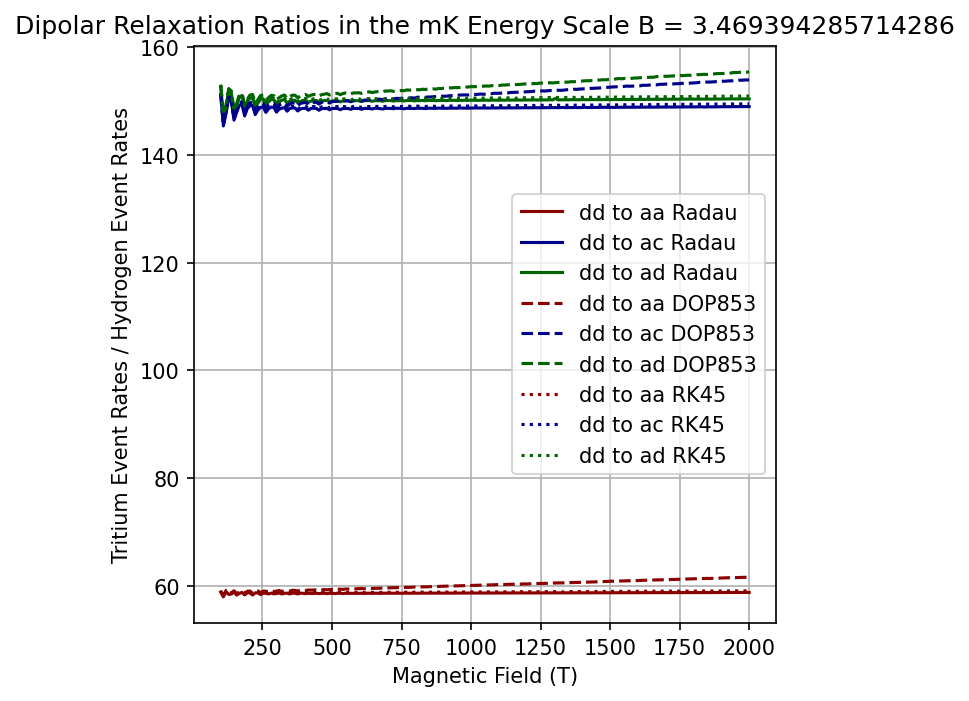

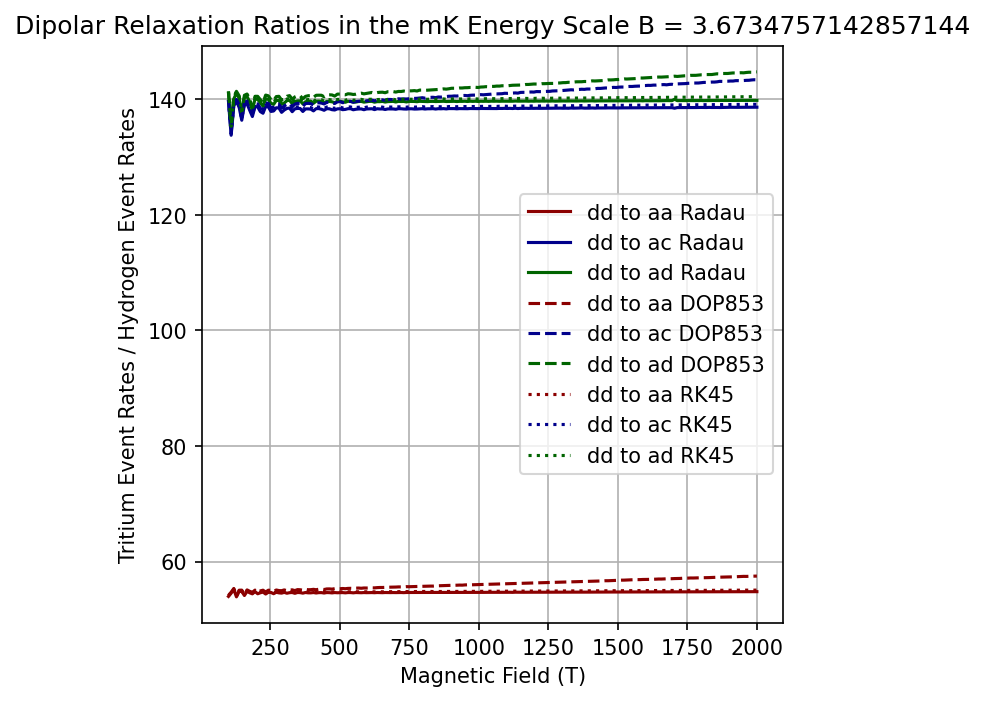

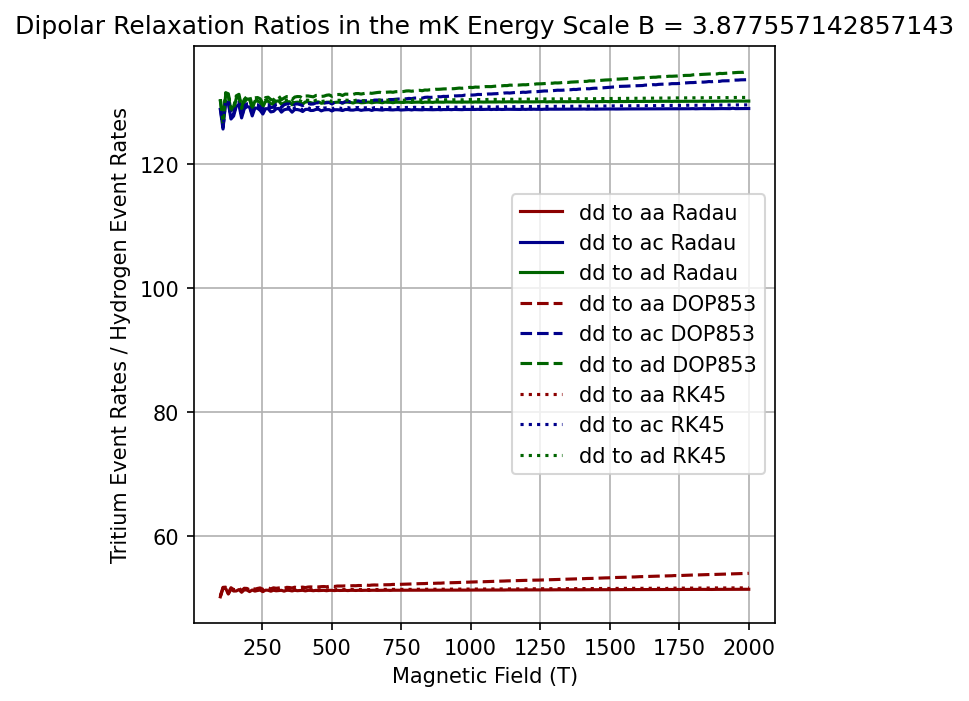

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  TIntegral2 = quad(TIntegrand,250,rhos[-1])[0]/(P1T*P2T)


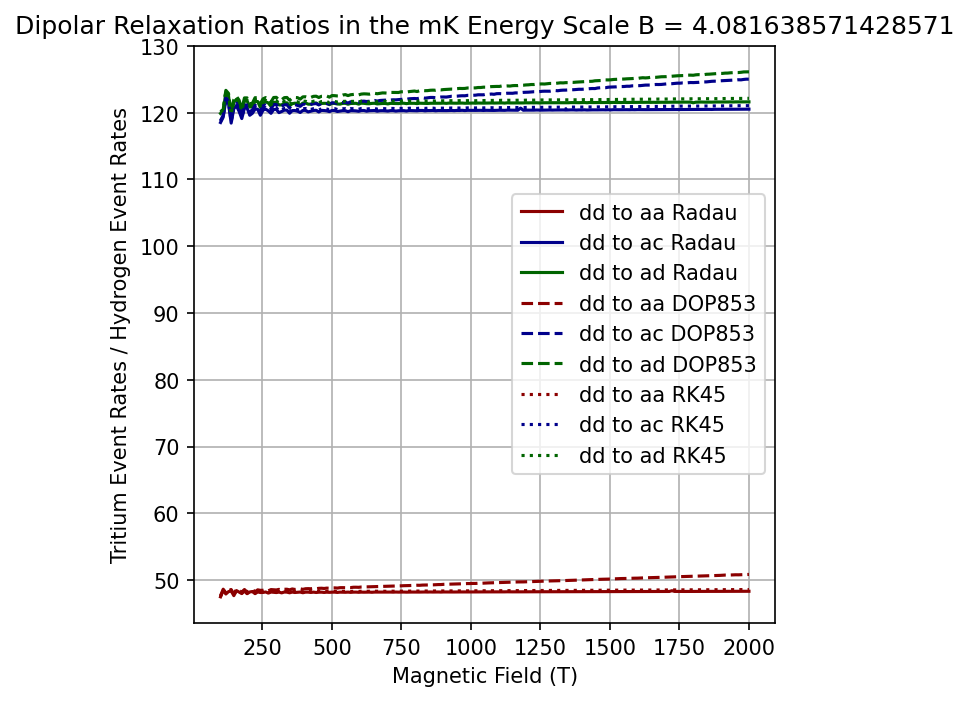

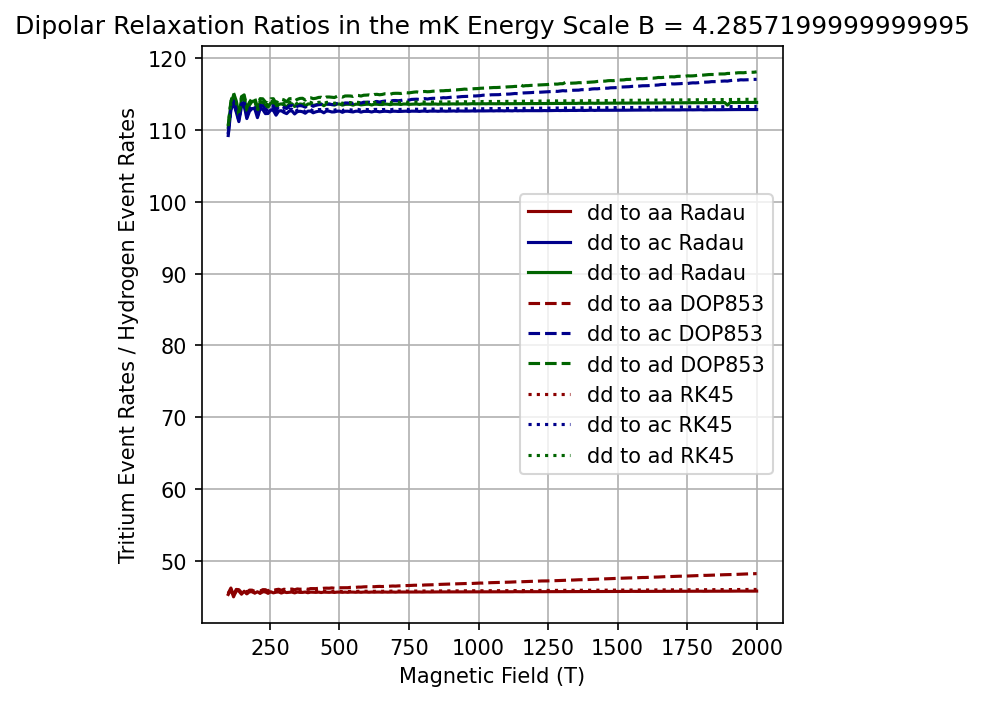

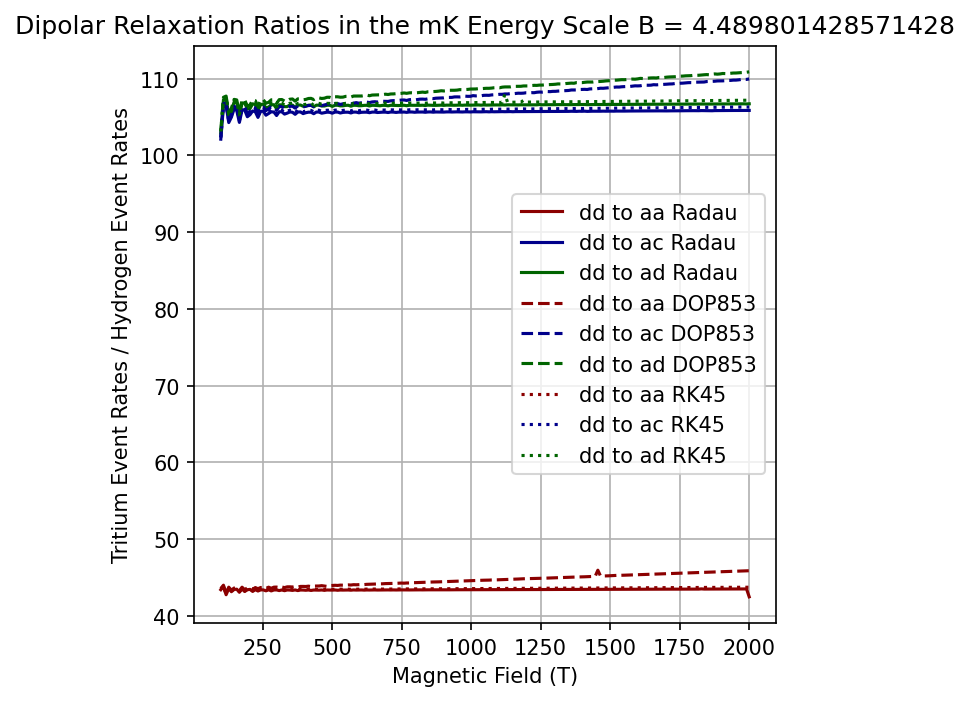

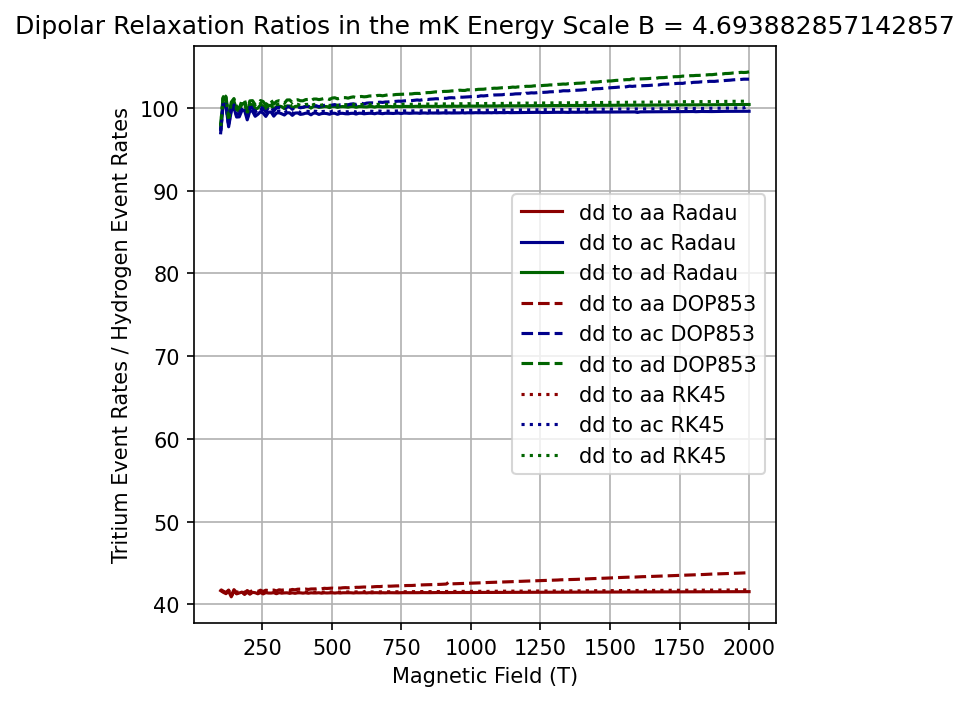

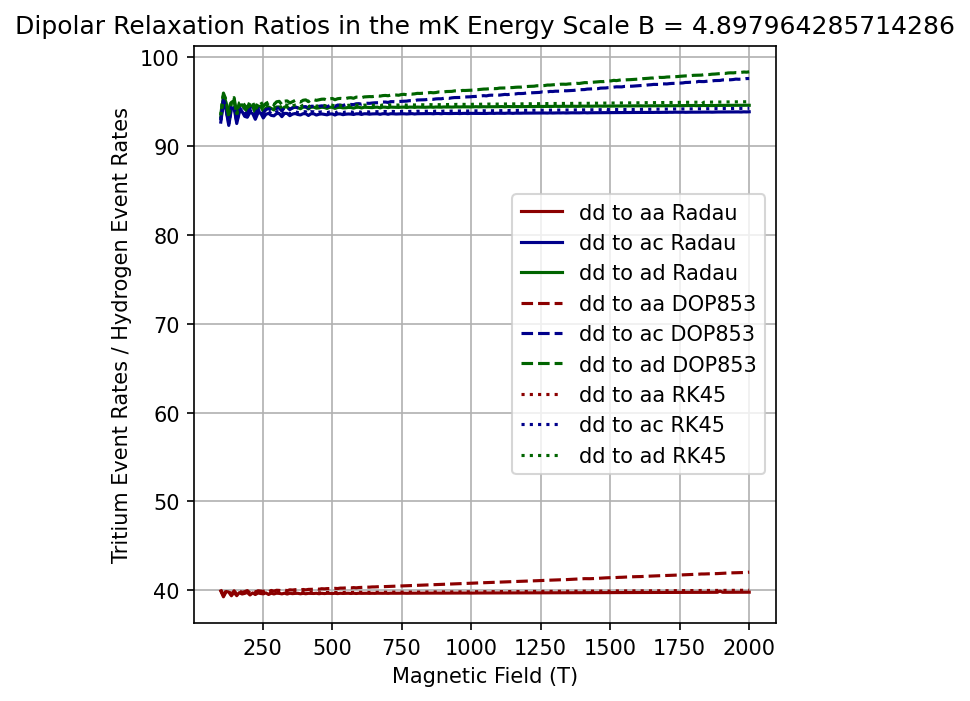

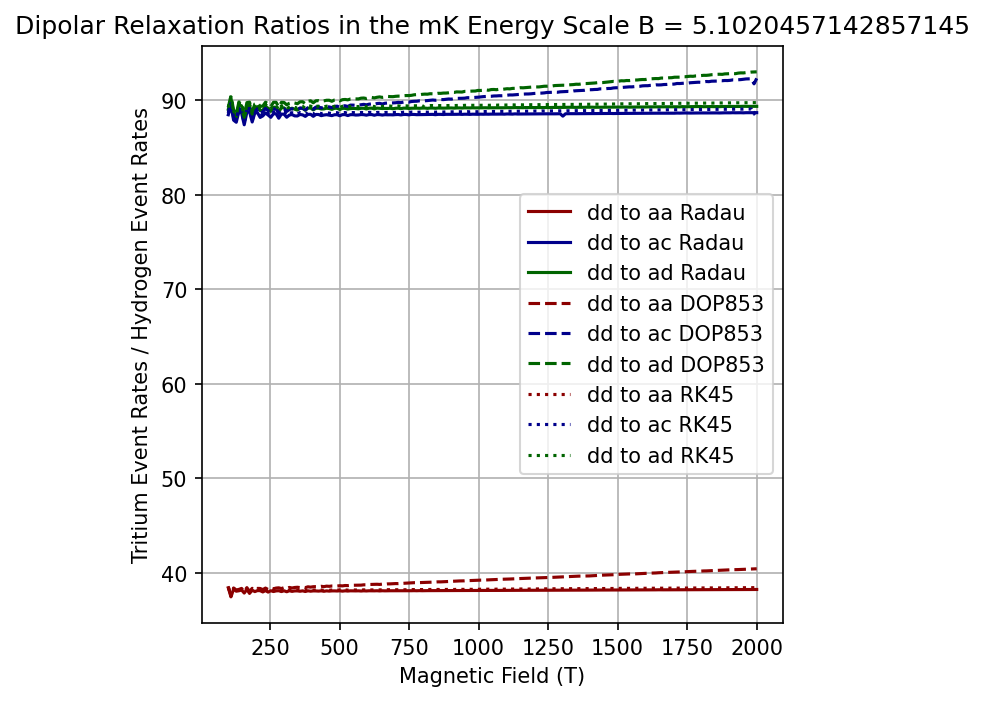

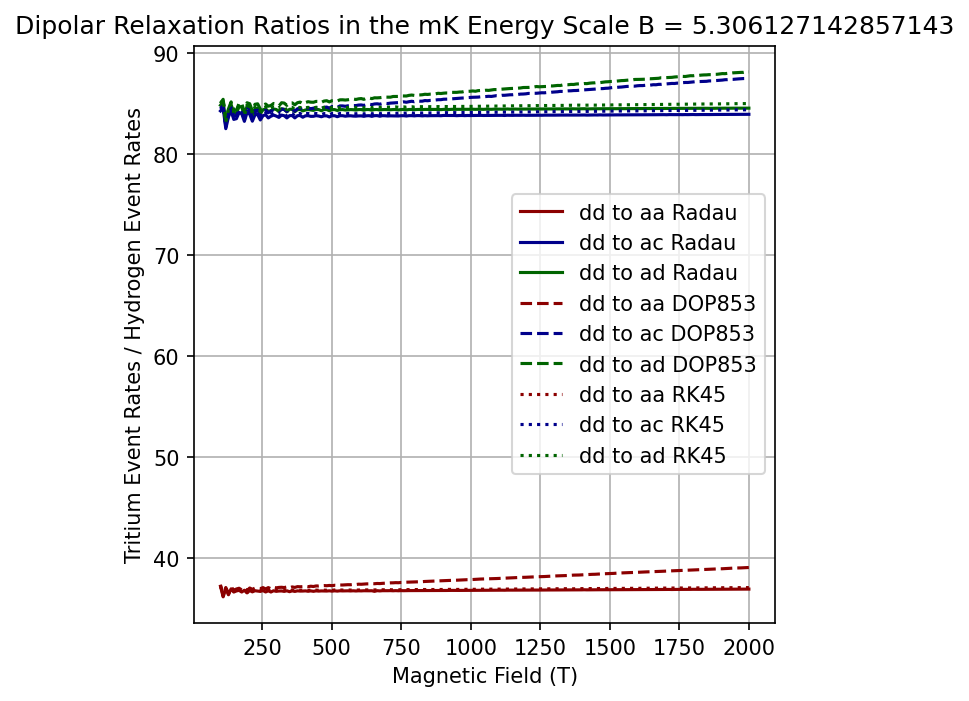

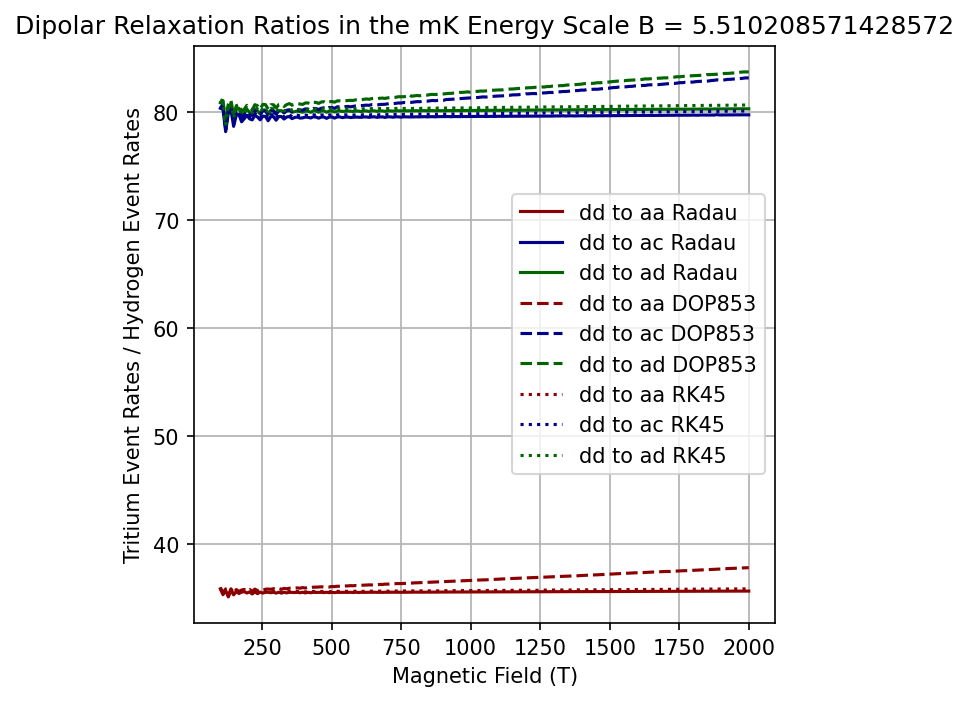

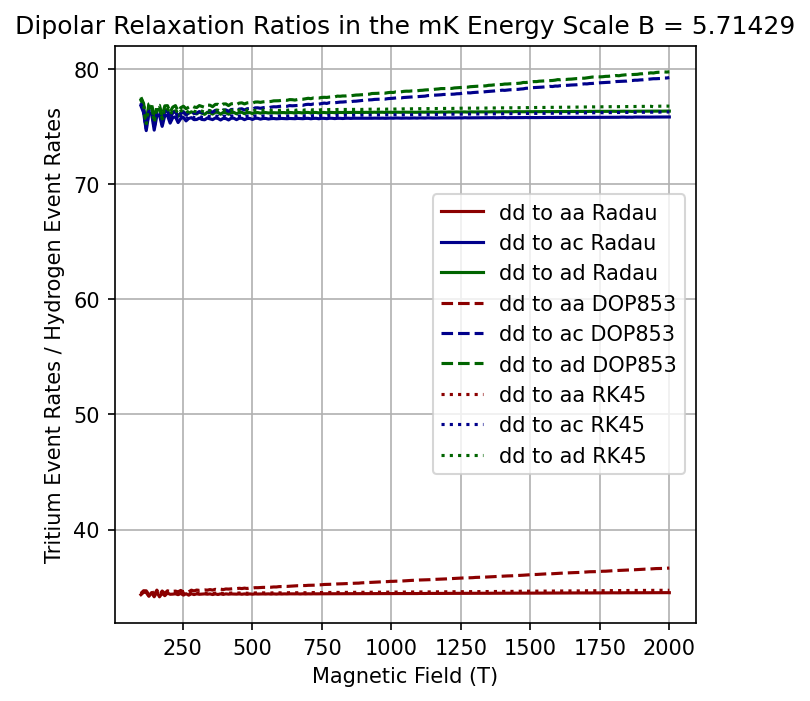

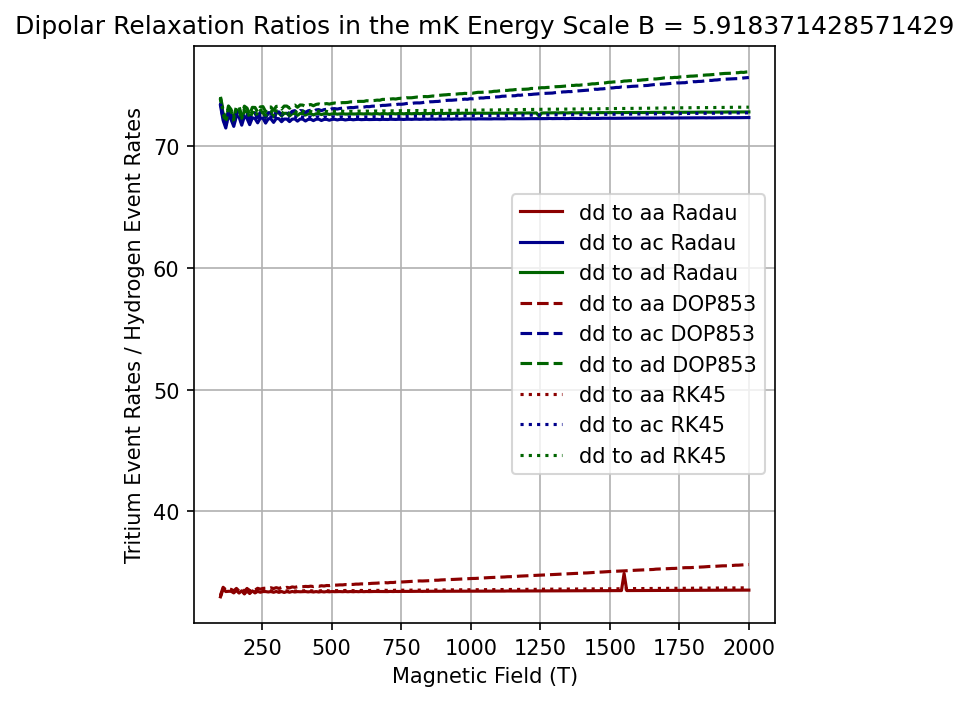

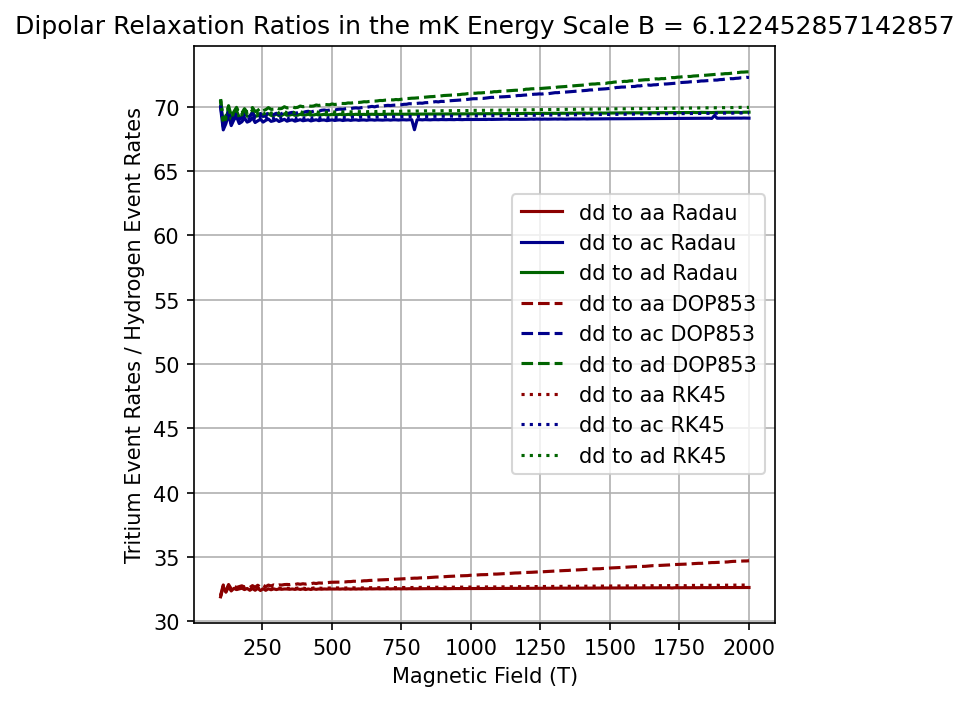

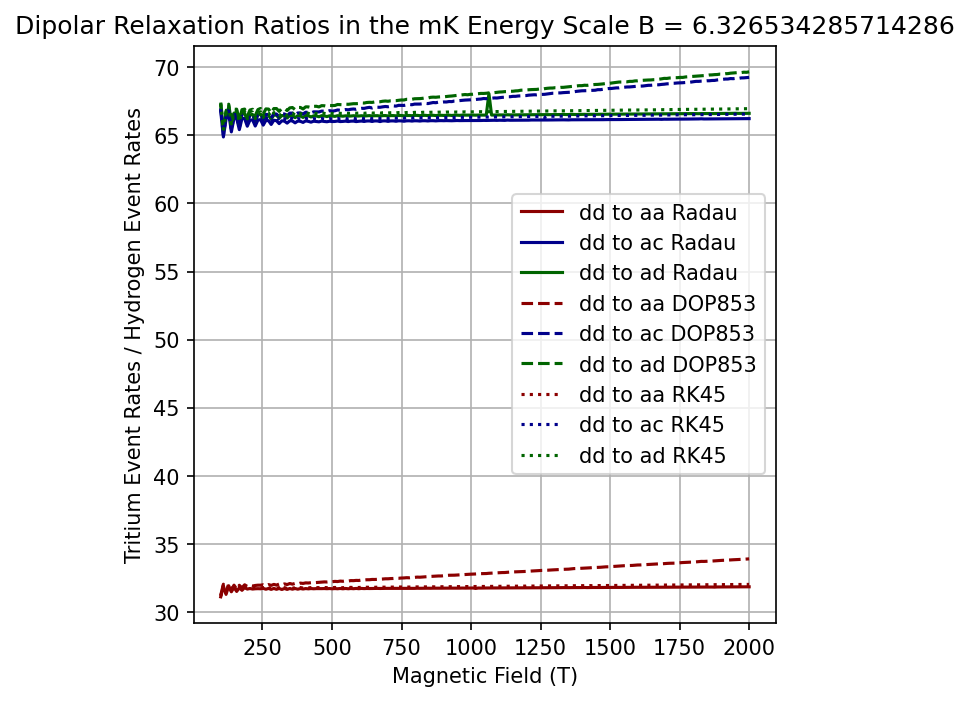

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_2720/390136712.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  HIntegral2 = quad(HIntegrand,250,rhos[-1])[0]/(P1H*P2H)


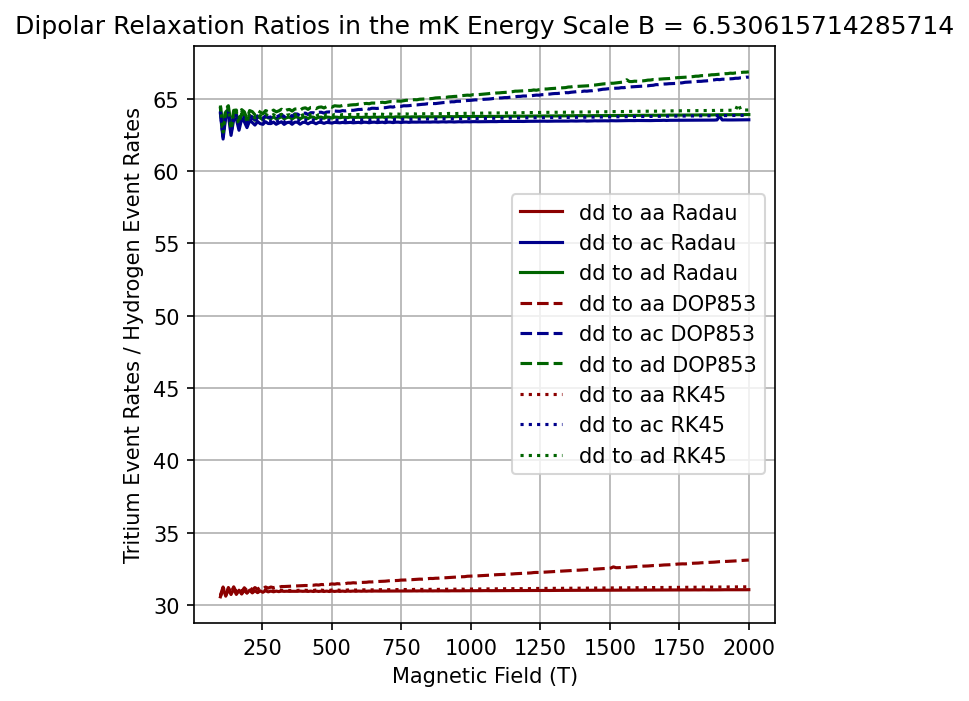

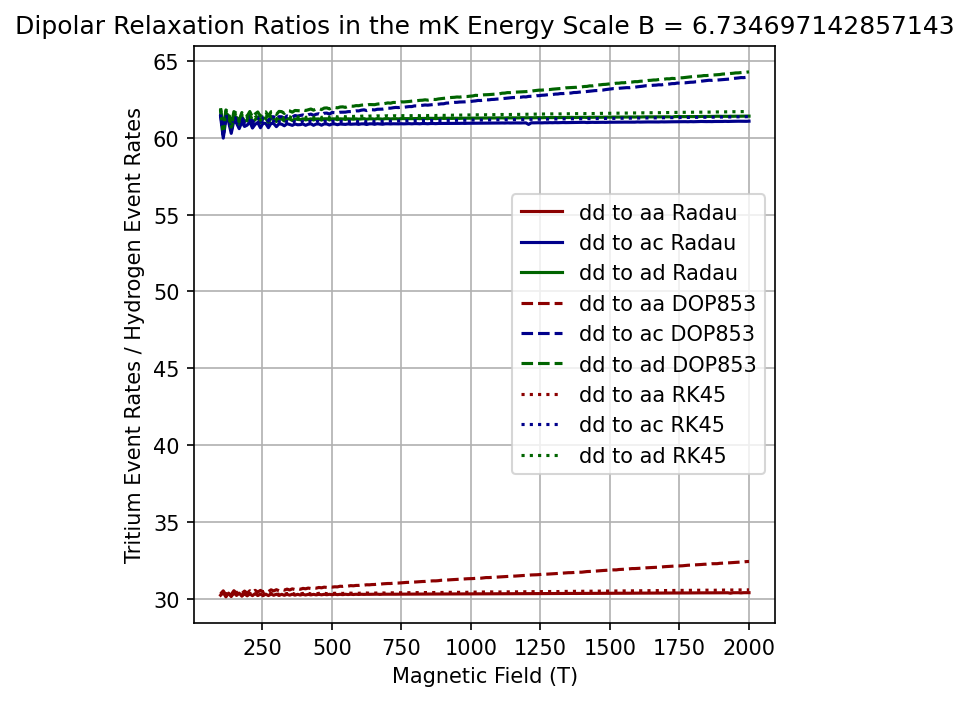

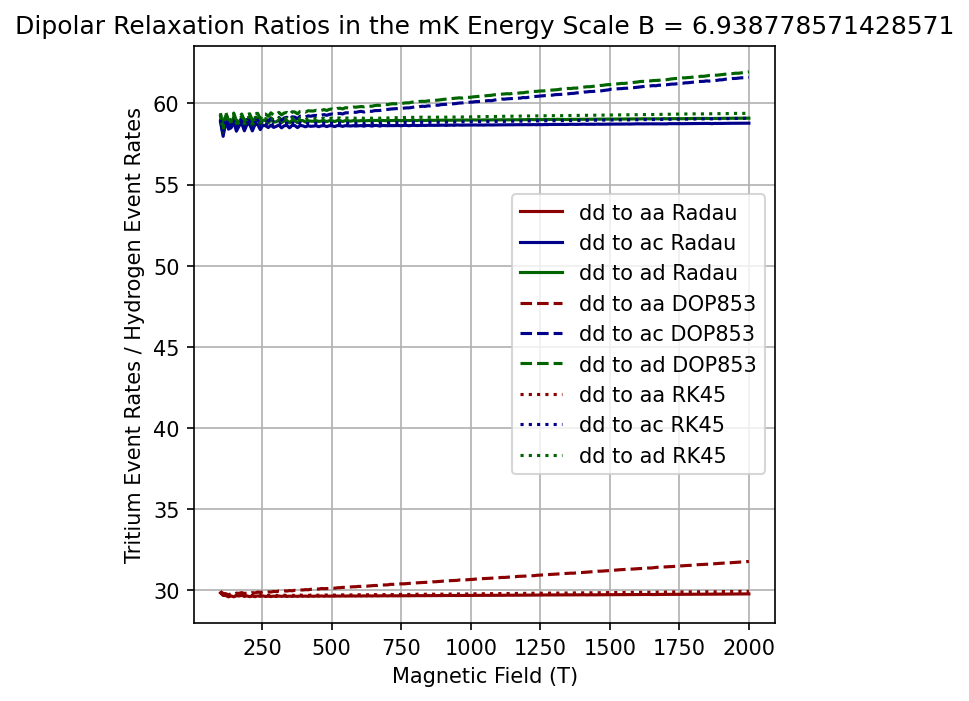

In [ ]:
Ls = np.linspace (100,2000,200)
i = 0
for smallfield in B:
    GHaa1_Elements = []
    GTaa1_Elements = []
    GHac1_Elements = []
    GTac1_Elements = []
    GHad1_Elements = []
    GTad1_Elements = []
    GHaa2_Elements = []
    GTaa2_Elements = []
    GHac2_Elements = []
    GTac2_Elements = []
    GHad2_Elements = []
    GTad2_Elements = []
    GHaa3_Elements = []
    GTaa3_Elements = []
    GHac3_Elements = []
    GTac3_Elements = []
    GHad3_Elements = []
    GTad3_Elements = []
    for intlimit in Ls: 
        for let in letters:
            a = Levels['d'][i] / invB2eV
            b = Levels['d'][i] / invB2eV
            alpha = Levels['a'][i] / invB2eV
            beta = Levels[let][i] / invB2eV                
            r0 = 1e-3
            temp = 1e-3
                
            P1H = p_of_temp( mH / (2 * kg2au) , temp)
            P1T = p_of_temp( mT / (2 * kg2au) , temp)
            P2H = pprime(P1H, a, b, alpha, beta, mH / (2 * kg2au))
            P2T = pprime(P1T, a, b, alpha, beta, mT / (2 * kg2au))

            IntegralsH1, IntegralsT1 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'Radau')
            IntegralsH2, IntegralsT2 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'DOP853')
            IntegralsH3, IntegralsT3 = GetIntegrals(a, b, alpha, beta, intlimit, r0, temp, 'RK45')
            
            GH1_Element = mH / (2 * kg2au) * P2H * IntegralsH1**2
            GT1_Element = mT / (2 * kg2au) * P2T * IntegralsT1**2
            GH2_Element = mH / (2 * kg2au) * P2H * IntegralsH2**2
            GT2_Element = mT / (2 * kg2au) * P2T * IntegralsT2**2
            GH3_Element = mH / (2 * kg2au) * P2H * IntegralsH3**2
            GT3_Element = mT / (2 * kg2au) * P2T * IntegralsT3**2
            
            if let == 'a':
                GHaa1_Elements.append(GH1_Element)
                GTaa1_Elements.append(GT1_Element)
                GHaa2_Elements.append(GH2_Element)
                GTaa2_Elements.append(GT2_Element)
                GHaa3_Elements.append(GH3_Element)
                GTaa3_Elements.append(GT3_Element)
            elif let == 'c':
                GHac1_Elements.append(GH1_Element)
                GTac1_Elements.append(GT1_Element)
                GHac2_Elements.append(GH2_Element)
                GTac2_Elements.append(GT2_Element)
                GHac3_Elements.append(GH3_Element)
                GTac3_Elements.append(GT3_Element)
            elif let == 'd':
                GHad1_Elements.append(GH1_Element)
                GTad1_Elements.append(GT1_Element) 
                GHad2_Elements.append(GH2_Element)
                GTad2_Elements.append(GT2_Element)
                GHad3_Elements.append(GH3_Element)
                GTad3_Elements.append(GT3_Element)

    GHaa1_Elements = np.array(GHaa1_Elements)
    GTaa1_Elements = np.array(GTaa1_Elements)
    GHac1_Elements = np.array(GHac1_Elements)
    GTac1_Elements = np.array(GTac1_Elements)
    GHad1_Elements = np.array(GHad1_Elements)
    GTad1_Elements = np.array(GTad1_Elements)
    GHaa2_Elements = np.array(GHaa2_Elements)
    GTaa2_Elements = np.array(GTaa2_Elements)
    GHac2_Elements = np.array(GHac2_Elements)
    GTac2_Elements = np.array(GTac2_Elements)
    GHad2_Elements = np.array(GHad2_Elements)
    GTad2_Elements = np.array(GTad2_Elements)               
    GHaa3_Elements = np.array(GHaa3_Elements)
    GTaa3_Elements = np.array(GTaa3_Elements)
    GHac3_Elements = np.array(GHac3_Elements)
    GTac3_Elements = np.array(GTac3_Elements)
    GHad3_Elements = np.array(GHad3_Elements)
    GTad3_Elements = np.array(GTad3_Elements)    

    plt.figure(figsize=(5, 5),dpi=150)
    plt.plot(Ls, GTaa1_Elements/GHaa1_Elements, label="dd to aa Radau",  color="DarkRed",   linestyle='-')
    plt.plot(Ls, GTac1_Elements/GHac1_Elements, label="dd to ac Radau",  color="DarkBlue",  linestyle='-')
    plt.plot(Ls, GTad1_Elements/GHad1_Elements, label="dd to ad Radau",  color="DarkGreen", linestyle='-')

    plt.plot(Ls, GTaa2_Elements/GHaa2_Elements, label="dd to aa DOP853", color="DarkRed",   linestyle='--')
    plt.plot(Ls, GTac2_Elements/GHac2_Elements, label="dd to ac DOP853", color="DarkBlue",  linestyle='--')
    plt.plot(Ls, GTad2_Elements/GHad2_Elements, label="dd to ad DOP853", color="DarkGreen", linestyle='--')

    plt.plot(Ls, GTaa3_Elements/GHaa3_Elements, label="dd to aa RK45",   color="DarkRed",   linestyle=':')
    plt.plot(Ls, GTac3_Elements/GHac3_Elements, label="dd to ac RK45",   color="DarkBlue",  linestyle=':')
    plt.plot(Ls, GTad3_Elements/GHad3_Elements, label="dd to ad RK45",   color="DarkGreen", linestyle=':')

    plt.xlabel("Magnetic Field (T)")
    #plt.xlim(0,.1)
    plt.ylabel("Tritium Event Rates / Hydrogen Event Rates")
    #plt.ylim(0,140)
    plt.title(f"Dipolar Relaxation Ratios in the mK Energy Scale B = {B[i]}")
    plt.grid(True)
    plt.legend()
    plt.show()
    i = i+1